## Standardize the item response data

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from funcs import *
from clustering import *
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_excel('data/pretest_data.xlsx', index_col= '번호')

In [3]:
response_data = np.array(data.drop(columns=['성적/10']))

In [4]:
data_standardized = (response_data - np.mean(response_data, axis=0)) / np.std(response_data, axis=0)

In [5]:
items_for_each_component = {'Repetition':[1],'Probability':[2,3],'Conditional_Probablity':[4,5],
                            'Random_Variable':[6,7],'Probability_Distribution':[8,9],'Statistical_Estimation':[10]}

## PCA (Principal Component Analysis)

Reduce dimension of the data from 10 to 7

In [6]:
fit_pca = PCA(n_components=7, random_state=0).fit_transform(data_standardized)

## K-means clustering

1. Choose the number of clusters

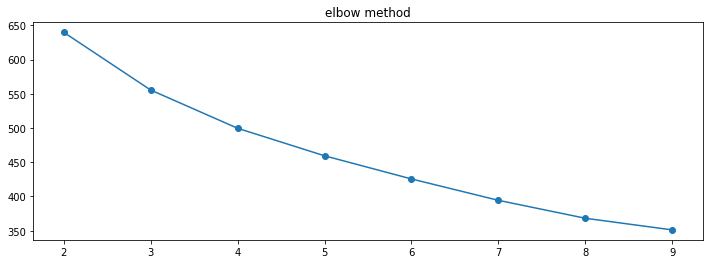

In [7]:
plt.figure(figsize=(12,4))
elbow_method(fit_pca)

In [8]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(fit_pca) for k in range(3, 7)]

In [9]:
sorted_index_list = list()
y_pred = list()

for k in range(len(kmeans_per_k)):
    sorted_index_list.append(np.argsort([np.mean(np.mean(data_standardized[kmeans_per_k[k].labels_ == i] ,axis=0)) 
                           for i in range(kmeans_per_k[k].n_clusters)])[::-1])

    y_pred.append(sort_categories_by_mean(kmeans_per_k[k].labels_, sorted_index_list[k]))

In [10]:
silhouette_scores_km = [silhouette_score(fit_pca, model.labels_) for model in kmeans_per_k]

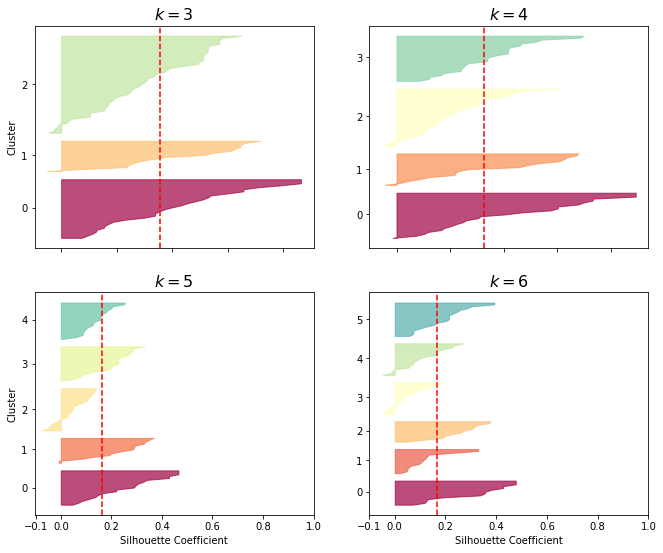

In [11]:
plot_silhouette_diagram(fit_pca, y_pred, silhouette_scores_km)
plt.show()

2. Total score distribution in k-means clustering

In [12]:
# Number of clusters in k-means clustering
num_cluster = 4

In [13]:
km_pca = KMeans(n_clusters=num_cluster, random_state=0).fit(fit_pca)

In [14]:
sorted_index = np.argsort([np.mean(np.mean(data_standardized[km_pca.labels_ == i] ,axis=0)) for i in range(num_cluster)])[::-1]

In [15]:
df_km = pd.DataFrame(fit_pca)
df_km['cluster_km'] = sort_categories_by_mean(km_pca.labels_, sorted_index)

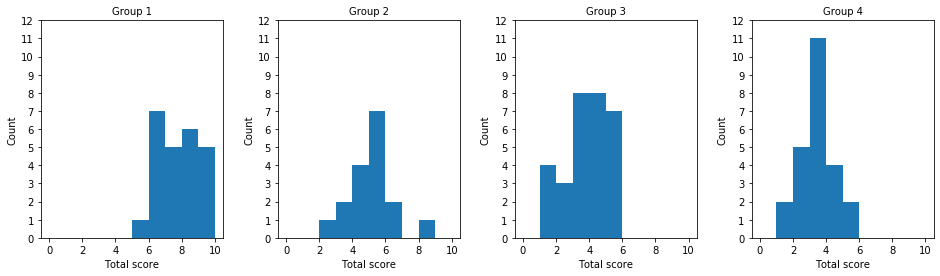

In [16]:
plt.figure(figsize=(16,4))
bins = np.linspace(0,10,11)
for i in range(num_cluster):
    plt.subplot(1,num_cluster,i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Group ' + str(i+1), fontsize=10)
    plt.xlabel('Total score')
    plt.ylabel('Count', fontsize=10)
    plt.hist(np.sum(response_data[df_km['cluster_km'] == i+1], axis = 1), bins = bins)
    plt.yticks(np.arange(0,13,1))

3. Itemwise score in k-means clustering

In [17]:
itemwise_km = [np.mean(data_standardized[df_km['cluster_km'] == i+1], axis=0) for i in range(num_cluster)]

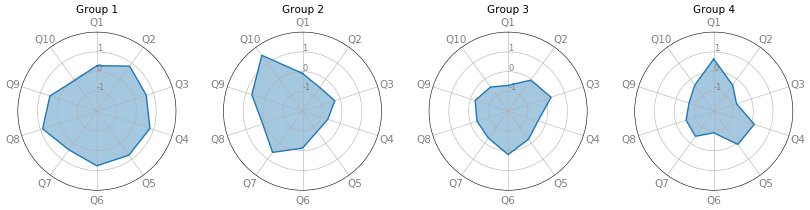

In [18]:
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(data_standardized.shape[1])]

for row in range(0, len(itemwise_km)):
    ax = plt.subplot(1,num_cluster,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = itemwise_km[row]
    make_spider(items, values, row, ax, 'Group ' + str(row + 1))

4. Componentwise score in k-means clustering

In [19]:
componentwise_km = list()

for i in range(1,num_cluster + 1):
    componentwise_km.append(calc_mean_components_by_group(items_for_each_component, itemwise_km, i))

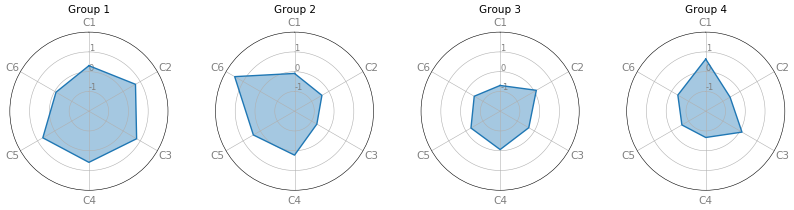

In [20]:
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_km)):
    ax = plt.subplot(1,num_cluster,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_km[row].values()
    make_spider(components, values, row, ax, 'Group '+ str(row + 1))

## Gaussian Mixture Model (GMM)

1. Choose the number of components

In [21]:
BIC = list()
AIC = list()
for i in range(1,8):
    gmm = GaussianMixture(n_components = i, random_state = 0)
    gmm.fit(fit_pca)
    BIC.append(gmm.bic(fit_pca))
    AIC.append(gmm.aic(fit_pca))

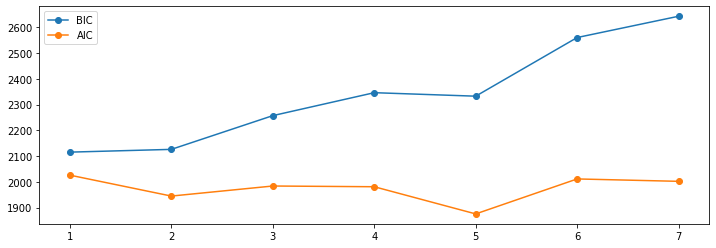

In [22]:
plt.figure(figsize=(12,4))
plt.plot(range(1,8),BIC,  'o-', label='BIC')
plt.plot(range(1,8),AIC, 'o-', label='AIC')
plt.legend()

2. Total score distribution in GMM

In [23]:
# Number of components in GMM
num_components = 5

In [24]:
gmm = GaussianMixture(n_components=num_components, random_state=0)

In [25]:
gmm.fit(fit_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [26]:
gmm_labels = gmm.predict(fit_pca)

In [27]:
sorted_index = np.argsort([np.mean(np.mean(data_standardized[gmm_labels == i] ,axis=0)) for i in range(num_components)])[::-1]

In [28]:
df_gmm = pd.DataFrame(fit_pca)
df_gmm['cluster_gmm'] = sort_categories_by_mean(gmm_labels, sorted_index)

In [29]:
gmm_cluster_index = df_gmm['cluster_gmm']

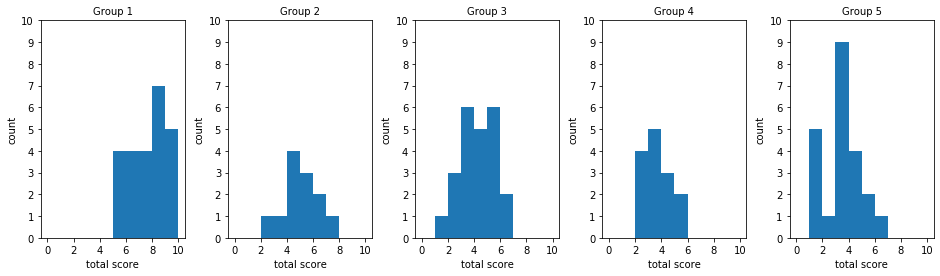

In [30]:
plt.figure(figsize=(16,4))
bins = np.linspace(0,10,11)
for i in range(num_components):
    plt.subplot(1,num_components,i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Group ' + str(i+1), fontsize=10)
    plt.xlabel('total score')
    plt.ylabel('count', fontsize=10)
    plt.hist(np.sum(response_data[df_gmm['cluster_gmm'] == i+1], axis = 1), bins = bins)
    plt.xticks(np.arange(0,11,2))
    plt.yticks(np.arange(0,11,1))

3. Itemwise score in GMM

In [31]:
itemwise_gmm = [np.mean(data_standardized[df_gmm['cluster_gmm'] == i+1], axis=0) for i in range(num_components)]

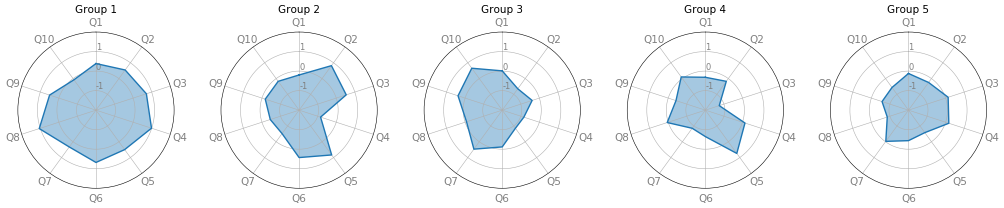

In [32]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(data_standardized.shape[1])]

for row in range(0, len(itemwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = itemwise_gmm[row]
    make_spider(items, values, row, ax, 'Group ' + str(row + 1))

4. Componentwise score in GMM

In [33]:
componentwise_gmm = list()

for i in range(1, num_components + 1):    
    componentwise_gmm.append(calc_mean_components_by_group(items_for_each_component, itemwise_gmm, i))

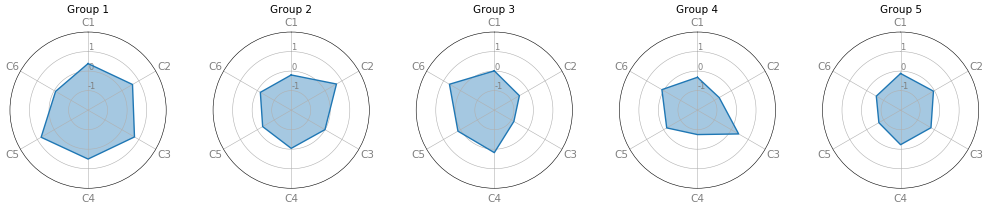

In [34]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_gmm[row].values()
    make_spider(components, values, row, ax, 'Group '+ str(row + 1))